In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#lib
import numpy as np
import matplotlib.pyplot as plt

import gym
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [ ]:
class ActorNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(ActorNetwork, self).__init__()

        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims=256, fc2_dims=256):
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        q = self.q(x)

        return q

In [ ]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
            np.array(self.actions),\
            np.array(self.probs),\
            np.array(self.vals),\
            np.array(self.rewards),\
            np.array(self.dones),\
            batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [ ]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='PPO/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = ActorNetwork(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = CriticNetwork()
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)

    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir + 'actor')
        self.critic.save(self.chkpt_dir + 'critic')

    def load_models(self):
      print("........loading models...........")
      self.actor = keras.models.load_model(self.chkpt_dir + "actor")
      self.critic = keras.models.load_model(self.chkpt_dir + "critic")

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])

        probs = self.actor(state)
        dist = tfp.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)

        action = action.numpy()[0]
        value = value.numpy()[0]
        log_prob = log_prob.numpy()[0]

        return action, log_prob, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1] * (
                        1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch])
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch])
                    actions = tf.convert_to_tensor(action_arr[batch])

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs)
                    new_probs = dist.log_prob(actions)

                    critic_value = self.critic(states)

                    critic_value = tf.squeeze(critic_value, 1)

                    prob_ratio = tf.math.exp(new_probs - old_probs)
                    weighted_probs = advantage[batch] * prob_ratio
                    clipped_probs = tf.clip_by_value(prob_ratio,
                                                     1-self.policy_clip,
                                                     1+self.policy_clip)
                    weighted_clipped_probs = clipped_probs * advantage[batch]
                    actor_loss = -tf.math.minimum(weighted_probs,
                                                  weighted_clipped_probs)
                    actor_loss = tf.math.reduce_mean(actor_loss)

                    returns = advantage[batch] + values[batch]
                    # critic_loss = tf.math.reduce_mean(tf.math.pow(
                    #                                  returns-critic_value, 2))
                    critic_loss = keras.losses.MSE(critic_value, returns)

                actor_params = self.actor.trainable_variables
                actor_grads = tape.gradient(actor_loss, actor_params)
                critic_params = self.critic.trainable_variables
                critic_grads = tape.gradient(critic_loss, critic_params)
                self.actor.optimizer.apply_gradients(
                        zip(actor_grads, actor_params))
                self.critic.optimizer.apply_gradients(
                        zip(critic_grads, critic_params))

        self.memory.clear_memory()

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-300):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average')
    plt.savefig(figure_file)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


... saving models ...
episode 0 score 20.0 avg score 20.0 time_steps 20 learning_steps 1
... saving models ...
episode 1 score 55.0 avg score 37.5 time_steps 75 learning_steps 3
episode 2 score 36.0 avg score 37.0 time_steps 111 learning_steps 5
episode 3 score 18.0 avg score 32.2 time_steps 129 learning_steps 6
episode 4 score 17.0 avg score 29.2 time_steps 146 learning_steps 7
episode 5 score 12.0 avg score 26.3 time_steps 158 learning_steps 7
episode 6 score 43.0 avg score 28.7 time_steps 201 learning_steps 10
episode 7 score 21.0 avg score 27.8 time_steps 222 learning_steps 11
episode 8 score 20.0 avg score 26.9 time_steps 242 learning_steps 12
episode 9 score 28.0 avg score 27.0 time_steps 270 learning_steps 13
episode 10 score 33.0 avg score 27.5 time_steps 303 learning_steps 15
episode 11 score 23.0 avg score 27.2 time_steps 326 learning_steps 16
episode 12 score 14.0 avg score 26.2 time_steps 340 learning_steps 17
episode 13 score 18.0 avg score 25.6 time_steps 358 learning_ste

FileNotFoundError: ignored

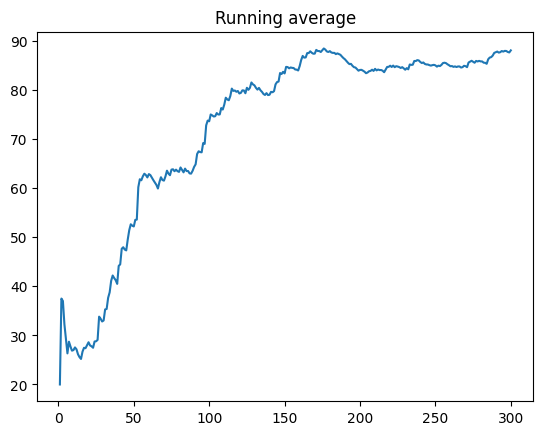

In [ ]:
if __name__ == '__main__':
    env = gym.make('CartPole-v1')
    N = 20
    batch_size = 5
    n_epochs = 4
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                  alpha=alpha, n_epochs=n_epochs,
                  input_dims=env.observation_space.shape)
    n_games = 300

    figure_file = 'plots/cartpole.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.store_transition(observation, action,
                                   prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-300:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
              'time_steps', n_steps, 'learning_steps', learn_iters)
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)